<a href="https://colab.research.google.com/github/davidbro-in/natural-language-processing/blob/main/4_next_word_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.inove.com.ar"><img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center"></a>


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [32]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# Descargar el dataset https://www.kaggle.com/arnavsharmaas/chatbot-dataset-topical-chat/version/1
df_original = pd.read_csv('/content/drive/MyDrive/CEIA 2021/Natural Language Processing/Datasets/topical_chat.csv')
df_original.head()

,conversation_id,message,sentiment
0,1,Are you a fan of Google or Microsoft?,Curious to dive deeper
1,1,Both are excellent technology they are helpfu...,Curious to dive deeper
2,1,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper
3,1,Google provides online related services and p...,Curious to dive deeper
4,1,"Yeah, their services are good. I'm just not a...",Curious to dive deeper


In [35]:
print("Cantidad de documentos:", df_original.shape[0])

Cantidad de documentos: 188378


In [36]:
# dropping duplicates
df_original.drop_duplicates(subset=['conversation_id', 'message'], inplace=True)

In [37]:
# Elimino la mayoría porque sino no alcanza la RAM
df_original.drop(df_original.index[1:185000], axis=0, inplace=True)

In [38]:
df_original.count()

conversation_id    3337
message            3337
sentiment          3337
dtype: int64

In [39]:
# basic preprocessing
def process(text):
    text = text.lower().replace('\n', ' ').replace('-', ' ').replace(':', ' ').replace(',', '') \
          .replace('"', '').replace("...", ".").replace("..", ".").replace("!", ".").replace("?", "").replace(";", ".").replace(":", " ")

    #text = "".join(v for v in text if v not in string.punctuation).lower()
    #text = text.encode("utf8").decode("ascii",'ignore')

    text = " ".join(text.split())
    #text+="<eos>"
    return text

In [40]:
df = df_original['message'].apply(process)  #aplica process a la columna message. 
df.head()

0                      are you a fan of google or microsoft
185042    yeah a little too much actually. not sure what...
185043    yeah wikileaks sure puts the government in a t...
185044    yeah too bad. there is a lot when it comes to ...
185045    wow 86% thats a lot of land i wonder if they u...
Name: message, dtype: object

### 1 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [41]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.preprocessing.sequence import pad_sequences # se utilizará para padding
#Queremos trasnformar el texto a termino

# largo de la secuencia, incluye seq input (3) + word output (1)
train_len = 4

In [42]:
# Vistazo a las primeras filas
df.loc[:15]
#df.loc(axis=1)[:15,0]
df.shape

(3337,)

In [43]:
# Concatenamos todos los rows en un solo valor
#tenemos una sola columna, se le llama "serie" cuando tengo un shape (188336,). Si teniamos varias columnas, habia que hacer un df.'columna', bla bla
#como aca hay una sola columna, convertimos directo a trsing y concatenamos
corpus = df.str.cat(sep = ' ')
corpus


"are you a fan of google or microsoft yeah a little too much actually. not sure what goes on behind those curtains i guess that is why wikileaks came about yeah wikileaks sure puts the government in a tough spot afterall the government planned to destroy it yeah too bad. there is a lot when it comes to politics and government really. apparently the government owns 86% percent of the land in nevada wow 86% thats a lot of land i wonder if they use it they should sell some of it and cover the deficit the government has yeah well most of it is desert land so i don't know. really i guess theres not much use to those lands then a man once sold the eiffel tower twice that is a great con man. how do you get away with that twice. he must have been a mastermind i know right i get it once but two times that must require a high level of skill. yeah. us now protects it workers from persecution if they go against the convention of geneva i guess thats a good thing as anyone can make mistakes and wor

In [44]:
len(corpus)

342036

In [45]:
# Transformar el corpus a tokens. Saca gilada, pero deja cosas propias de las palabras, comoapostrofes. Saca signo exclamacion
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
print(tokens[:20])
len(tokens)

['are', 'you', 'a', 'fan', 'of', 'google', 'or', 'microsoft', 'yeah', 'a', 'little', 'too', 'much', 'actually', 'not', 'sure', 'what', 'goes', 'on', 'behind']


65713

In [46]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

len(text_sequences)

65709

In [47]:
# Demos un vistazo a nuestros vectores para entrenar el modelo. Ventana movil de tamaño 4
text_sequences[:20]
#len(tokens)

[['are', 'you', 'a', 'fan'],
 ['you', 'a', 'fan', 'of'],
 ['a', 'fan', 'of', 'google'],
 ['fan', 'of', 'google', 'or'],
 ['of', 'google', 'or', 'microsoft'],
 ['google', 'or', 'microsoft', 'yeah'],
 ['or', 'microsoft', 'yeah', 'a'],
 ['microsoft', 'yeah', 'a', 'little'],
 ['yeah', 'a', 'little', 'too'],
 ['a', 'little', 'too', 'much'],
 ['little', 'too', 'much', 'actually'],
 ['too', 'much', 'actually', 'not'],
 ['much', 'actually', 'not', 'sure'],
 ['actually', 'not', 'sure', 'what'],
 ['not', 'sure', 'what', 'goes'],
 ['sure', 'what', 'goes', 'on'],
 ['what', 'goes', 'on', 'behind'],
 ['goes', 'on', 'behind', 'those'],
 ['on', 'behind', 'those', 'curtains'],
 ['behind', 'those', 'curtains', 'i']]

In [48]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) #fit de todo el corpus.

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

#Esto sería el dataset

[[23, 6, 3, 122],
 [6, 3, 122, 7],
 [3, 122, 7, 747],
 [122, 7, 747, 65],
 [7, 747, 65, 2725],
 [747, 65, 2725, 30],
 [65, 2725, 30, 3],
 [2725, 30, 3, 309],
 [30, 3, 309, 43],
 [3, 309, 43, 49],
 [309, 43, 49, 119],
 [43, 49, 119, 21],
 [49, 119, 21, 72],
 [119, 21, 72, 37],
 [21, 72, 37, 652],
 [72, 37, 652, 25],
 [37, 652, 25, 519],
 [652, 25, 519, 134],
 [25, 519, 134, 2726],
 [519, 134, 2726, 2]]

### 3 - Input y target

In [49]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])

print(ex)

print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

[[1 2 3 4]
 [5 6 7 8]]
Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [50]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [51]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]  #x son numeros, IDs
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder. Comunmente represento las categorias (aca palabras) en un OneHotEnconder. 
#Va a tener el tamaño de palabras que se pueden predecir

print(x_data.shape)
print(y_data_int.shape)
print(y_data_int)
print(x_data)

(65709, 3)
(65709,)
[122   7 747 ...  64 746  18]
[[ 23   6   3]
 [  6   3 122]
 [  3 122   7]
 ...
 [678 727  14]
 [727  14  64]
 [ 14  64 746]]


In [52]:
# Palabras del vocabulario
len(tok.index_word)

5209

In [53]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

5209

In [54]:
# Transformar los datos a oneHotEncoding. Abajo la solucion al error
# y_data = to_categorical(y_data_int, num_classes=vocab_size)

In [55]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [56]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(65709, 5209)

### 4 - Entrenar el modelo

In [57]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [58]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

5209

In [59]:
model = Sequential()

#Explicacion: lstm agrupado con lstm. La primera tiene que tener la return sequence. Para jugar tiramos uno dropout. La unica diferencia es que la primera capa 
#es la capa de embedding. Por qué? Se encargan de trasnformar mis palabras en un vector. Ver que no estamos entrando con un OneHotEncodder.

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable). para un vocabulario de 20.000 palabras, se suelen usar 100 dim. 300 sería mucho
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))


model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3, 5)              26050     
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 64)             17920     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 64)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 5209)              171897    
Total params: 250,971
Trainable params: 250,971
Non-trainable params: 0
________________________________________________

In [60]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
1643/1643 [==============================] - 26s 14ms/step - loss: 6.5283 - accuracy: 0.0417 - val_loss: 6.5067 - val_accuracy: 0.0364
Epoch 2/50
1643/1643 [==============================] - 22s 13ms/step - loss: 6.2141 - accuracy: 0.0477 - val_loss: 6.5263 - val_accuracy: 0.0582
Epoch 3/50
1643/1643 [==============================] - 21s 13ms/step - loss: 6.0019 - accuracy: 0.0713 - val_loss: 6.3724 - val_accuracy: 0.0753
Epoch 4/50
1643/1643 [==============================] - 21s 13ms/step - loss: 5.7777 - accuracy: 0.0827 - val_loss: 6.3977 - val_accuracy: 0.0851
Epoch 5/50
1643/1643 [==============================] - 21s 13ms/step - loss: 5.6011 - accuracy: 0.0938 - val_loss: 6.4069 - val_accuracy: 0.0862
Epoch 6/50
1643/1643 [==============================] - 22s 13ms/step - loss: 5.4577 - accuracy: 0.1053 - val_loss: 6.4508 - val_accuracy: 0.0975
Epoch 7/50
1643/1643 [==============================] - 21s 13ms/step - loss: 5.3171 - accuracy: 0.1161 - val_loss: 6.4509 -

Por qué da malo? El dataset es bastante chico. Además de que hay que probar un poco con los hiperparámentros

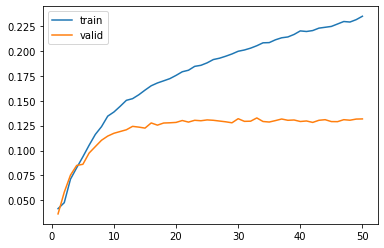

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

Claramente un OVERFITTING, faltan datos para que no haga overfitting. 

### 5 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [62]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     |████████████████████████████████| 3.6 MB 5.3 MB/s 
     |████████████████████████████████| 1.9 MB 29.0 MB/s 
     |████████████████████████████████| 206 kB 45.8 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
     |████████████████████████████████| 961 kB 43.6 MB/s 
     |████████████████████████████████| 3.5 MB 32.0 MB/s 


In [63]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')  #trunco para que no se rompa el código
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
This share link will expire in 72 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted
Running on External URL: https://52929.gradio.app


KeyboardInterrupt: ignored

### 6 - Generación de secuencias nuevas

Para que prediga varias palabras

In [64]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [65]:
#misma entrada da la misma salida

input_text='Hi man how'

generate_seq(model, tok, input_text, max_length=3, n_words=10)

'Hi man how of         '

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.